# Ongoing work

Researching on the portfolios made by taking weights as the eigenvectors of stock return matrix. 

In [15]:
import pandas as pd
from datetime import datetime
import eikon as ek
import calendar
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")

from time import sleep
ek.set_app_key('APP_KEY')


# Getting EigenPortfolio: Multiple methods

We train the trading model on previous month's returns for our stock universe and use the resulting eigenweights as the current portfolio weights. 
However since there are many eigenvectors, choosing the correct vector is essentially the problem. Following are the methods so far tried:
1) Choose by cross validation on the some part of unseen data 
2) Choose the vector with largest eigen values or a group of N large eigenvalues
3) Choose the vector with smallest eigen values or a group of N small eigenvalues for the inverse cov matrix (As suggested by Irine Aldridge in her paper)

In [16]:


def Get_EigenPort_Weights(data):
    
    universe = data.columns.tolist()
    scaler = preprocessing.StandardScaler()

    train, validation = train_test_split(data,shuffle=False,test_size=0.3)

    covariance_matrix = data.cov()
    
    D, S = np.linalg.eigh(np.linalg.inv(covariance_matrix))
    eigenlist = []
    retlist = []
    for p in range(1,len(S)):
        eigenportfolio_final = 0*S[:,0]
        cumrets = 0
        for i in range(1,p):
            eigenportfolio_1 = S[:,-i] 
            eigenportfolio = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = universe)
            cumulative_returns = get_cumulative_returns_over_time(validation, eigenportfolio).values[-1][0]
            if(cumulative_returns > 0):
                eigenportfolio_final = np.add(eigenportfolio_final,S[:,-i])
            else:
                eigenportfolio_final = np.add(eigenportfolio_final,-S[:,-i])
            eigenportfolio_final = np.add(eigenportfolio_final,S[:,-i])
        eigenportfolio = pd.DataFrame(data= eigenportfolio_final, columns = ['Investment Weight'], index = universe)
        rets = get_cumulative_returns_over_time(data, eigenportfolio).values[-1][0]
        retlist.append(abs(rets))
        sign = rets/abs(rets)
        eigenlist.append(sign*eigenportfolio)
        maxindex = retlist.index(max(retlist,key=abs))
        port = (eigenlist[maxindex])/(eigenlist[maxindex]).sum()
    return port/port.std()

def get_top_rics_by_mktcap(top,date):
    return ek.get_data("0#.NIFTY100","TR.CompanyMarketCap",{'Sdate':date})[0].sort_values(by='Company Market Cap',ascending=False).Instrument[:top].tolist()

def get_cumulative_returns_over_time(sample, weights):
    return (((1+sample).cumprod(axis=0))-1).dot(weights)


# Backtesting on the eignenportfolio 

Following lines test on a year's daily data where the portfolio is rebalanced on a monthly basis. It prints the portweights monthly as the code runs and shows the final returns of the strategy with respect to benchmark

2015-1-3 2015-1-31


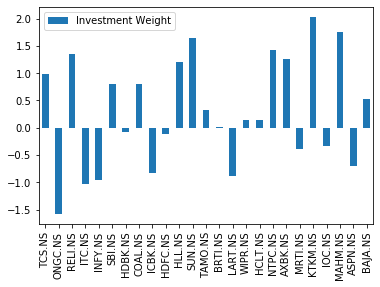

2015-2-6 2015-2-28


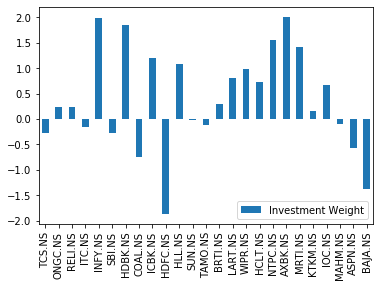

2015-3-6 2015-3-31


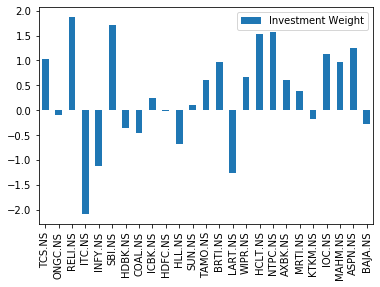

2015-4-2 2015-4-30


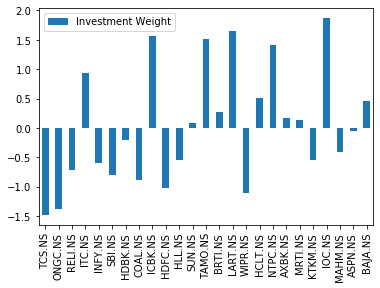

2015-5-4 2015-5-31


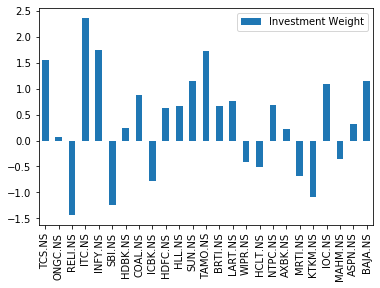

2015-6-1 2015-6-30


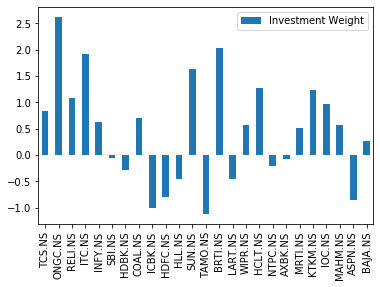

2015-7-2 2015-7-31


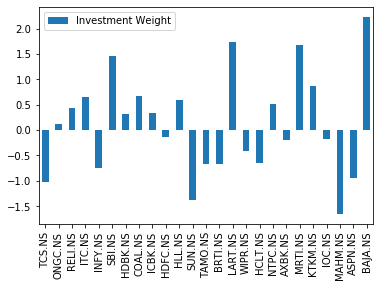

2015-8-5 2015-8-31


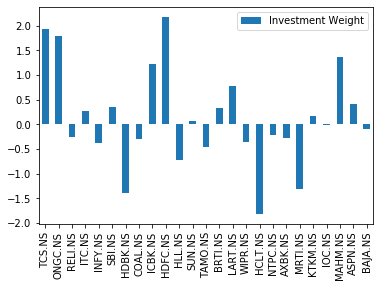

2015-9-1 2015-9-30


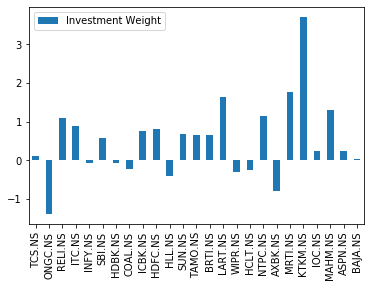

2015-10-3 2015-10-31


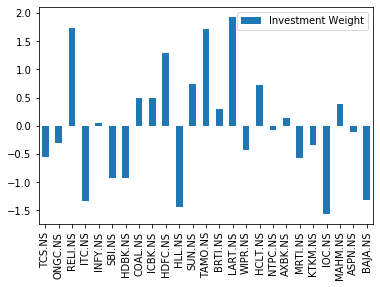

2015-11-6 2015-11-30


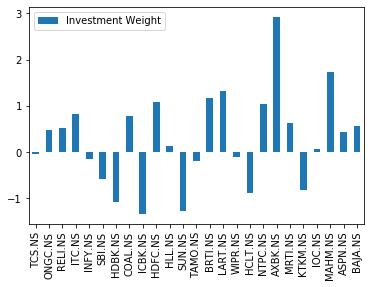

2015-12-1 2015-12-31


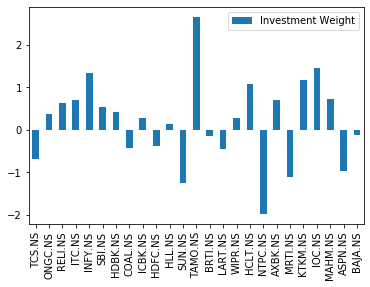

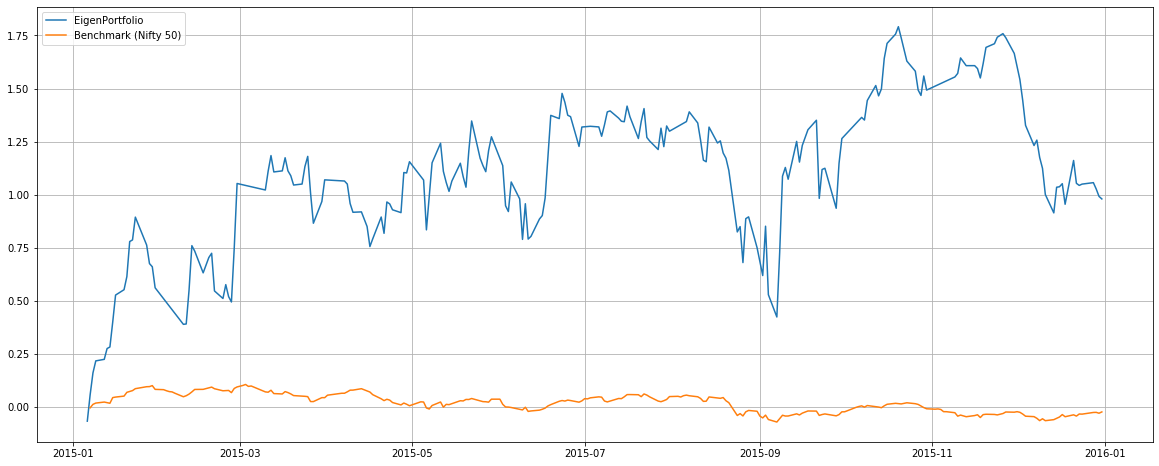

In [17]:

daily_returns = pd.DataFrame()

YEAR = 2015

start_date = str(YEAR-1) + '-12-01'
end_date = str(YEAR-1) + '-12-31'

Universe = get_top_rics_by_mktcap(25,start_date)

prices = ek.get_timeseries(rics=Universe,fields=['CLOSE'],
                            start_date=start_date,
                            end_date=end_date,
                            interval='daily',corax='adjusted')
returns = prices.pct_change()

# returns = np.log(prices) - np.log(prices.shift(1))


returns = returns.iloc[1:, :]

portwts = Get_EigenPort_Weights(returns)


for i in range(12):
    start_date = str(YEAR)+str("-")+str(i+1)+str("-") + str(max(calendar.monthrange(YEAR,i+1)[0],1))
    end_date =  str(YEAR)+str("-")+str(i+1)+str("-") + str(calendar.monthrange(YEAR,i+1)[1])
    
    print(start_date,end_date)

    #To Show Plots
    portwts.plot(kind='bar', legend=True,label='EigenPortfolio Weights')

    plt.show()
    
    prices = ek.get_timeseries(rics=Universe,fields=['CLOSE'],
                            start_date=start_date,
                            end_date=end_date,
                            interval='daily',corax='adjusted')
    
    returns = prices.pct_change()
    returns = returns.iloc[1:, :]
#     returns.clip(lower=-0.1,upper=0.1,inplace=True)

    if(i > 0):
        
        rets = get_cumulative_returns_over_time(returns,portwts) + (daily_returns.values[-1][0])
    else:
        rets = get_cumulative_returns_over_time(returns,portwts)
        
    #Apply stoploss to portfolio
#     rets[rets[rets.pct_change() < -0.2].first_valid_index():] = rets[rets[rets.pct_change() < -0.2].first_valid_index():].iloc[0][0]

    daily_returns = daily_returns.append(rets)
    
    
    portwts = Get_EigenPort_Weights(returns)
    sleep(1)

    
nifty = ek.get_timeseries(rics=['.NSEI'],fields=['CLOSE'],
                            start_date=str(daily_returns.index[0].date()),
                            end_date=str(daily_returns.index[-1].date()),
                            interval='daily',corax='adjusted')
indexreturns = nifty.pct_change()
indexreturns = indexreturns.iloc[1:, :]

fig = plt.figure(figsize=(20,8))
ax = fig.gca()
ax.grid()

plt.plot(daily_returns,label='EigenPortfolio')
plt.plot((((1+indexreturns).cumprod(axis=0))-1),label='Benchmark (Nifty 50)')
plt.legend()


